###imports

In [49]:
import zipfile
import os
import tensorflow as tf
import shutil
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


###Extracting Dataset

In [50]:
def extract_dataset() :
  zip_path = '/content/Teeth DataSet.zip'
  extract_path = 'content/'
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)


In [51]:
extract_dataset()

In [ ]:
train_ds_path = "/content/content/Teeth_Dataset/Training"
test_ds_path='/content/content/Teeth_Dataset/Testing'
val_ds_path='/content/content/Teeth_Dataset/Validation'

###Remove test incorrect files

In [52]:
for dirpath, dirnames, filenames in os.walk(test_ds_path):
  for dir in dirnames :
    if dir in ["output","outputs","out"] :
      shutil.rmtree(os.path.join(test_ds_path,dir))

os.remove(os.path.join(test_ds_path,'output_image.jpg'))

###Load DataSet

In [53]:


batch_size = 32
img_size = (128, 128)
train = tf.keras.utils.image_dataset_from_directory(
    train_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)
val = tf.keras.utils.image_dataset_from_directory(
    val_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=img_size,
    shuffle=True
)
test = tf.keras.utils.image_dataset_from_directory(
    test_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=img_size,
    shuffle=True
)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


### Visualization one Batch

Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32,)


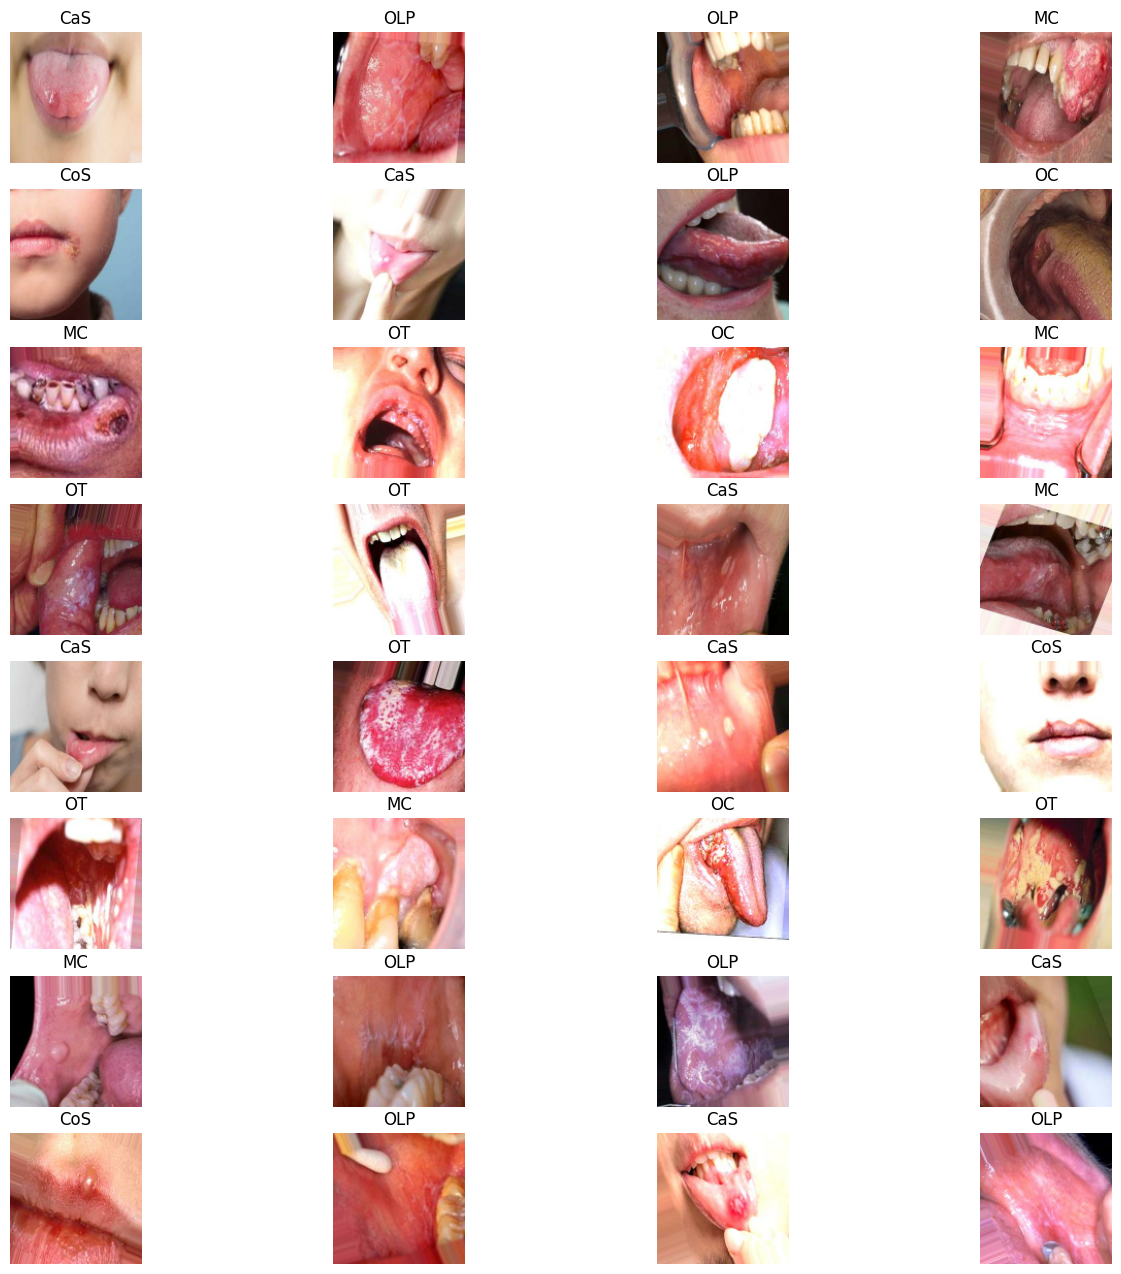

In [54]:
for images, labels in train.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    plt.figure(figsize=(16, 16))
    for index in range(32) :
      ax = plt.subplot(8, 4, index+1)
      plt.imshow(images[index].numpy().astype("uint8"))
      plt.title(train.class_names[labels[index]])
      plt.axis("off")
    plt.show()

###Preprocessing

In [55]:
normalization = tf.keras.layers.Rescaling(1./255)

train = train.map(lambda x, y: (normalization(x), y))
val = val.map(lambda x, y: (normalization(x), y))
test = test.map(lambda x, y: (normalization(x), y))

In [56]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomRotation(0.4),
])

In [57]:
train_after_augmentation = train.map(lambda x, y: (data_augmentation(x,training=True), y))

###Visualization

In [62]:
distribute_classes=dict()
for dirpath, dirnames, filenames in os.walk(train_ds_path):
  for dir in dirnames :
    fulldir = os.path.join(train_ds_path,dir)
    distribute_classes[dir]= len(os.listdir(fulldir))
print(distribute_classes)

{'MC': 540, 'OC': 324, 'OLP': 540, 'Gum': 360, 'OT': 393, 'CaS': 480, 'CoS': 450}


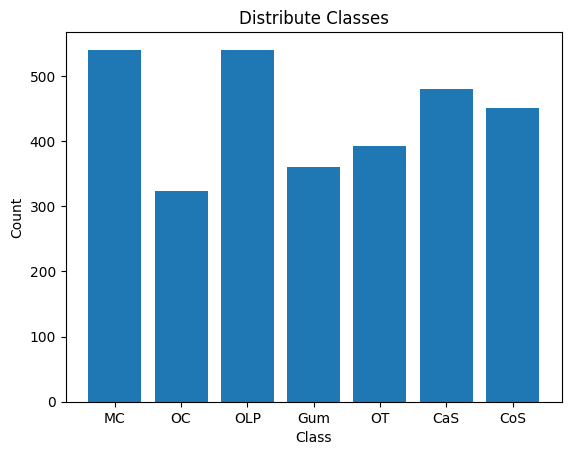

In [65]:
plt.bar(distribute_classes.keys(),distribute_classes.values())
plt.title("Distribute Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

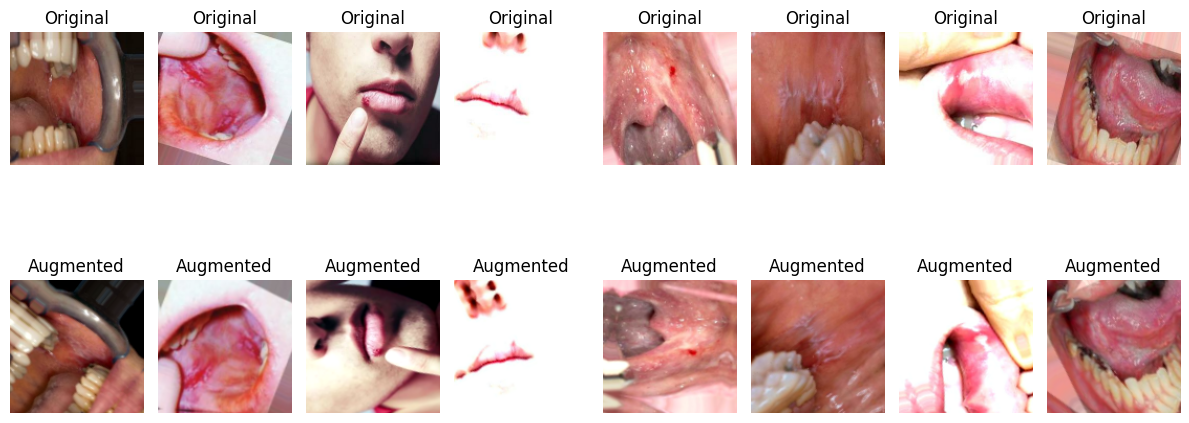

In [58]:
for images, labels in train.take(1):
    plt.figure(figsize=(12, 6))

    for i in range(8):
        ax = plt.subplot(2, 8, i + 1)
        img = images[i]
        plt.imshow(tf.cast((img*255), tf.uint8))
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2, 8, i + 1 + 8)
        aug_img = data_augmentation(tf.expand_dims(img, 0))
        plt.imshow(tf.cast((aug_img[0]*255), tf.uint8))
        plt.title("Augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
